## Observational trigger frequency

In [1]:
from pathlib import Path
import sys
import os

import rioxarray
from shapely.geometry import mapping
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt

mpl.rcParams['figure.dpi'] = 300

Set config values and parameters.

In [21]:
path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
sys.path.append(path_mod)
from src.indicators.drought.config import Config

config = Config()
parameters = config.parameters('mwi')
COUNTRY_ISO3 = parameters["iso3_code"]
DATA_DIR = Path(config.DATA_DIR)

RAW_DIR =  DATA_DIR / config.PUBLIC_DIR / config.RAW_DIR / COUNTRY_ISO3
ARC2_DIR = DATA_DIR / config.PUBLIC_DIR / 'exploration' / COUNTRY_ISO3 / 'arc2'
DRY_SPELLS = 'mwi_arc2_dry_spells.csv'
PLOT_DIR = DATA_DIR / 'public' / 'processed' / COUNTRY_ISO3 / 'plots' / 'dry_spells' / 'arc2'

N_YEARS = 21 # Dry spells based on 21 years of ARC2 data - from 2000-2020, inclusive

Read in the dry spells data and convert data types.

In [3]:
df = pd.read_csv(ARC2_DIR / DRY_SPELLS)
df['dry_spell_confirmation'] = pd.to_datetime(df['dry_spell_confirmation'])

Keep only dry spells that were confirmed within the monitoring period of Jan 1 - Feb 28. This means that the dry spells could begin as early as Dec 18th.

In [4]:
monitoring_start = "2014-01-01" # The year doesn't matter here
monitoring_end = "2014-02-28" # The year doesn't matter here

monitoring = pd.Series(pd.date_range(monitoring_start, monitoring_end))
monitoring_no_year = monitoring.map(lambda x: x.strftime("%m-%d"))
df["no_year"] = df['dry_spell_confirmation'].map(lambda x: x.strftime("%m-%d"))
no_year_mask = df['no_year'].isin(monitoring_no_year)
df_filtered = df[no_year_mask].sort_values(by='dry_spell_confirmation')

Also only keep the dry spells that are in the Southern region (MW3).

In [5]:
df_filtered = df_filtered[df_filtered['pcode'].str.startswith('MW3')]

Look into various scenarios for activating, based on different thresholds for number of regions experiencing a dry spell.

In [6]:
df_activations = df_filtered.groupby('dry_spell_confirmation').size().reset_index(name='n_adm2')
df_activations['year'] = df_activations['dry_spell_confirmation'].dt.year

In [31]:
df_activations

,dry_spell_confirmation,n_adm2,year
0,2005-02-11,1,2005
1,2005-02-12,4,2005
2,2005-02-13,1,2005
3,2008-02-22,2,2008
4,2008-02-23,6,2008
5,2010-01-13,11,2010
6,2011-02-23,1,2011
7,2011-02-24,3,2011
8,2016-01-09,1,2016
9,2016-02-14,1,2016


Output statistics include: 
- `thresh`: number of admin regions with a dry spell confirmed on a given date
- `tot_act`: total number of times the trigger would be met, *potentially in the same season*
- `tot_years`: total number of times the trigger would be met, *assuming it can only happen once / season*
- `freq_act`: `tot_act` / total number of monitoring years
- `freq_years`: `tot_years` / total number of monitoring yeats
- `mult_cases`: number of years that have multiple cases where the trigger would be met

In [29]:
threshs = range(1, 6) # Different options for number of regions

df_stats = pd.DataFrame(columns = ['thresh', 'tot_act', 'tot_years', 'freq_act', 'freq_years', 'mult_cases'])

for thresh in threshs: 

    df_activations_filter = df_activations[df_activations['n_adm2'] >= thresh]

    tot_act = len(df_activations_filter.index)
    tot_years = len(df_activations_filter.year.unique())
    freq_act = tot_act / N_YEARS
    freq_years = tot_years / N_YEARS

    count_mult = df_activations_filter.groupby('year').size().reset_index(name='n_mult_years')
    mult_cases = len(count_mult[count_mult['n_mult_years'] > 1])

    row = {
        'thresh': thresh, 
        'tot_act': tot_act, 
        'tot_years': tot_years, 
        'freq_act': freq_act, 
        'freq_years': freq_years, 
        'mult_cases': mult_cases
    }

    df_stats = df_stats.append(row, ignore_index=True)

In [30]:
df_stats

,thresh,tot_act,tot_years,freq_act,freq_years,mult_cases
0,1.0,13.0,6.0,0.619048,0.285714,5.0
1,2.0,5.0,4.0,0.238095,0.190476,1.0
2,3.0,4.0,4.0,0.190476,0.190476,0.0
3,4.0,3.0,3.0,0.142857,0.142857,0.0
4,5.0,2.0,2.0,0.095238,0.095238,0.0


Plot to explore the results.

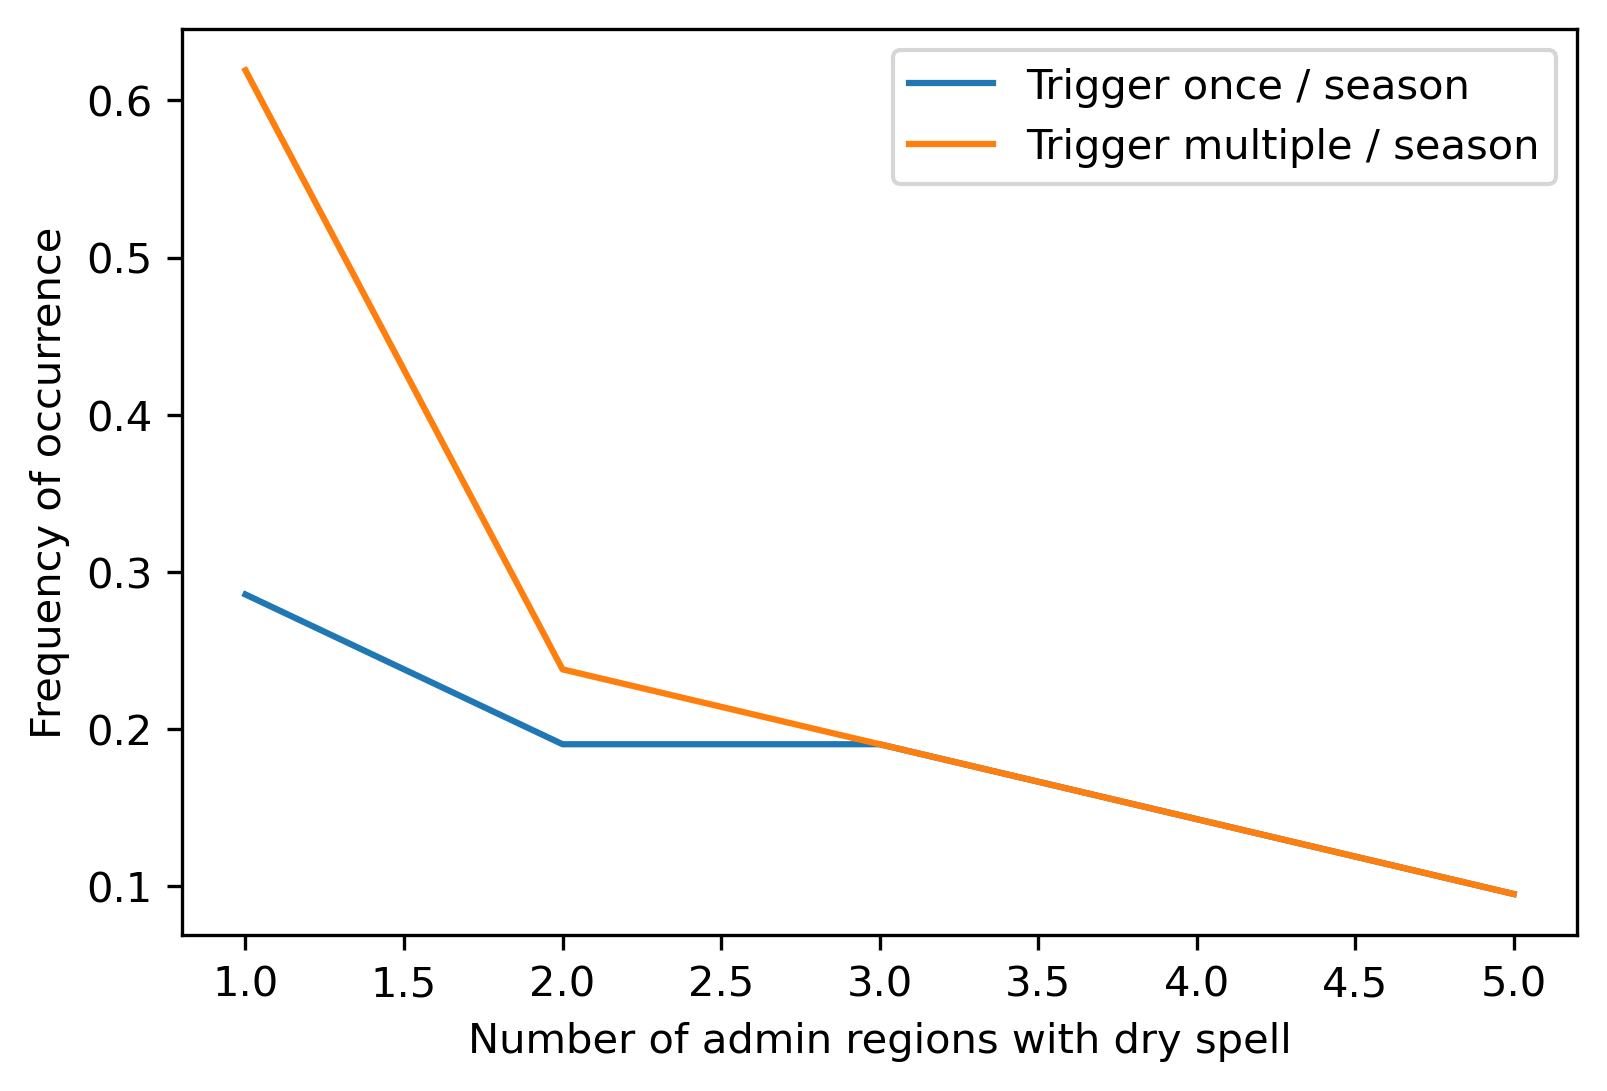

In [38]:
plt.plot(df_stats['thresh'], df_stats['freq_years'], label='Trigger once / season')
plt.plot(df_stats['thresh'], df_stats['freq_act'], label='Trigger multiple / season')
plt.legend()
plt.ylabel('Frequency of occurrence')
plt.xlabel('Number of admin regions with dry spell')
plt.show()

Now explore the results if we add a buffer around when we consider different admin regions to be simultaneously triggering. For example, many of the dry spells are confirmed within several days of each other, but they aren't counted as happening together with the above method. If identify dry spells occurring in multiple admin regions within a matter of days of each other, we should probably count these together.

In [39]:
# TODO